<a href="https://colab.research.google.com/github/EgorSolovei/Computer-Vision/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install unrar

In [2]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2024-02-08 11:11:10--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2024-02-08 11:11:10--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5bd1d77628d4e0f5d9ff48250f.dl.dropboxusercontent.com/cd/0/inline/CM5Jht8xZ53FCXX8asr6rWL7FvtkkbFg4_raRpUZ3zNj3Fc5gkAChYtrXiayOtGmoNn52UVkwIfuJxppLKfj1UkVBlT7mzaIQBe6bUoSweZfPPyWMyAq6zzo0OV5Ue5_Tu0/file# [following]
--2024-02-08 11:11:11--  https://uc5bd1d77628d4e0f5d9ff48250f.dl.dropboxusercontent.com/cd/0/inline/CM5Jht8xZ53FCXX8asr6rWL7FvtkkbFg4_raRpUZ3zNj3Fc5gkAChYtrXiayOtGmoNn52UVkwIfuJxppLKfj1UkVBlT7mzaIQBe6bUoSweZfPPyWMy

In [3]:
! ls

PH2Dataset.rar	sample_data


In [4]:
%%capture
! unrar x /content/PH2Dataset.rar

# Imports

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from IPython.display import clear_output
from torchvision import models
from torch.utils.data import DataLoader
from time import time
from matplotlib import rcParams

rcParams['figure.figsize'] = (15,4)

In [6]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [7]:
images[0].shape

(576, 767, 3)

In [8]:
images[0]

array([[[75, 69, 53],
        [75, 69, 53],
        [77, 72, 53],
        ...,
        [82, 74, 71],
        [66, 61, 58],
        [ 8,  4,  3]],

       [[75, 73, 60],
        [74, 72, 59],
        [76, 72, 60],
        ...,
        [80, 72, 69],
        [66, 61, 58],
        [ 6,  2,  1]],

       [[77, 70, 60],
        [73, 66, 56],
        [77, 70, 60],
        ...,
        [74, 70, 67],
        [56, 55, 53],
        [ 2,  2,  0]],

       ...,

       [[58, 42, 27],
        [51, 33, 19],
        [57, 38, 23],
        ...,
        [50, 36, 35],
        [44, 34, 33],
        [10,  1,  2]],

       [[73, 45, 41],
        [61, 34, 27],
        [66, 37, 29],
        ...,
        [52, 36, 37],
        [52, 40, 42],
        [ 8,  0,  0]],

       [[70, 52, 42],
        [52, 32, 23],
        [55, 33, 22],
        ...,
        [ 3,  0,  0],
        [ 5,  4,  2],
        [ 0,  0,  0]]], dtype=uint8)

In [9]:
lesions[0].shape

(576, 767)

In [10]:
size = (256, 256)

# приведём к одному размеру изображения и сразу же сделаем нормировку
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [11]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

print(f'Loaded {len(X)} images')

Loaded 200 images


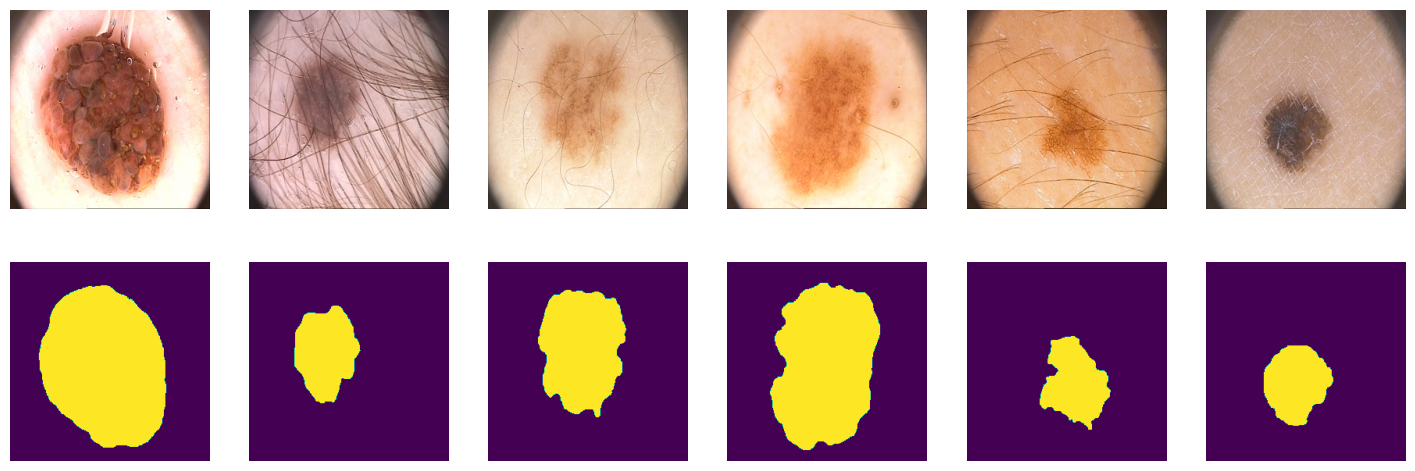

In [12]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [13]:
ix = np.random.choice(len(X), len(X), False)
train, val, test = np.split(ix, [100, 150])

# Data Loader

In [14]:
batch_size = 25

data_train = DataLoader(list(zip(np.rollaxis(X[train], 3, 1), Y[train, np.newaxis])),
                        batch_size=batch_size, shuffle=True)

data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)

data_test = DataLoader(list(zip(np.rollaxis(X[test], 3, 1), Y[test, np.newaxis])),
                       batch_size=batch_size, shuffle=True)

In [15]:
len(data_train)

4

In [16]:
list(zip(np.rollaxis(X[train], 3, 1), Y[train, np.newaxis]))[0][0].shape

(3, 256, 256)

In [17]:
Y[train, np.newaxis][0] # нужно для того, чтобы создать 3 мерный канал, для согласования

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [18]:
# размер батча и 3 канала у входящей картинки и 1 канал у выходной картинки
for data, label in data_train:
    print(data.shape, label.shape)
    break

torch.Size([25, 3, 256, 256]) torch.Size([25, 1, 256, 256])


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# SegNet

In [20]:
! nvidia-smi

Thu Feb  8 11:11:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
class SegNet(nn.Module):

    def __init__(self, label_nbr): # label_nbr - количество классов
        super(SegNet, self).__init__()

        # первый слой
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # второй слой
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # третий слой
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # четвертый слой
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # пятый слой
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # обратный пятый слой
        self.conv5_d = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU()
        )

        # обратный четвёртый слой
        self.conv4_d = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
        )

        # обратный третий слой
        self.conv3_d = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
        )

        # обратный второй слой
        self.conv2_d = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
        )

        # обратный первый слой - последний
        self.conv1_d = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)
        )


    def forward(self, x):

        # Stage 1. Необходимо возвращать индексы, чтобы использовать в decoder
        x1 = self.conv1(x)
        x1p, id1 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)

        # Stage 2
        x2 = self.conv2(x1p)
        x2p, id2 = F.max_pool2d(x2,kernel_size=2, stride=2, return_indices=True)

        # Stage 3
        x3 = self.conv3(x2p)
        x3p, id3 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)

        # Stage 4
        x4 = self.conv4(x3p)
        x4p, id4 = F.max_pool2d(x4, kernel_size=2, stride=2, return_indices=True)

        # Stage 5
        x5 = self.conv5(x4p)
        x5p, id5 = F.max_pool2d(x5, kernel_size=2, stride=2, return_indices=True)


        # Stage 5d - начинаем разворачивать картинку
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2)
        x5d = self.conv5_d(x5d)

        # Stage 4d
        x4d = F.max_unpool2d(x5d, id4, kernel_size=2, stride=2)
        x4d = self.conv4_d(x4d)

        # Stage 3d
        x3d = F.max_unpool2d(x4d, id3, kernel_size=2, stride=2)
        x3d = self.conv3_d(x3d)

        # Stage 2d
        x2d = F.max_unpool2d(x3d, id2, kernel_size=2, stride=2)
        x2d = self.conv2_d(x2d)

        # Stage 1d
        x1d = F.max_unpool2d(x2d, id1, kernel_size=2, stride=2)
        x1d = self.conv1_d(x1d)

        return x1d

# Train model


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [22]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    SMOOTH = 1e-8
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou

In [23]:
def train(model, opt, epochs, data_train, data_val, loss_fn):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_metric = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_train:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()  # backward-pass
            opt.step()  # update weights
            opt.zero_grad() # set parameter gradients to zero

            avg_loss += loss / len(data_train) # calculate loss to show the user

        print('Loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        X_val = X_val.to(device)
        Y_hat = model(X_val)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            X_val = X_val.to('cpu')
            Y_hat = Y_hat.to('cpu')
            Y_hat = Y_hat.detach()

            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k-1].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k-1, 0].numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch+1}/{epochs}. Loss: {avg_loss:.5f}')
        plt.show()

In [24]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [25]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0

    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)

        Y_pred = model(X_batch)
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

In [26]:
model = SegNet(1).to(device)

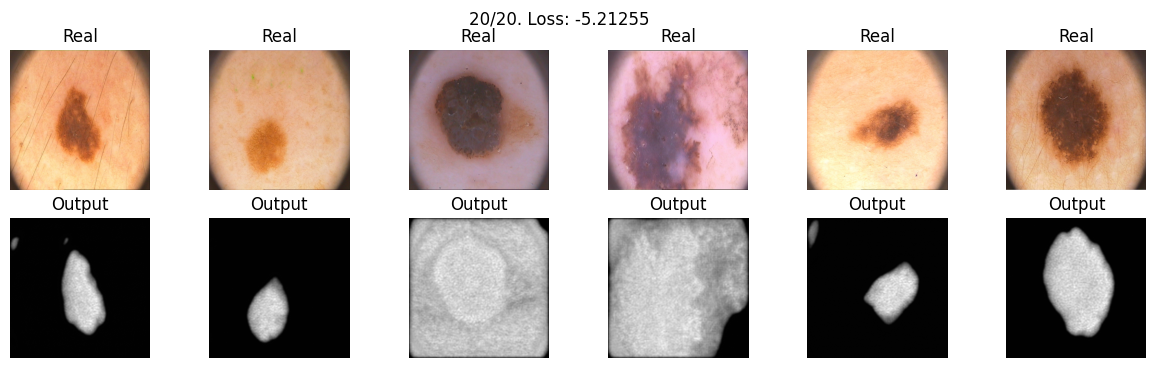

In [27]:
max_epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.BCEWithLogitsLoss()

train(model, optim, max_epochs, data_train, data_val, loss_fn)

In [ ]:
# calculate metric on train and test data
# print(f"Train metric: {score_model(model, iou_pytorch, data_train)}")
# print(f"Test metric: {score_model(model, iou_pytorch, data_test)}")